In [1]:
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats

In [2]:
# Change data paths to your own
metadata = pd.read_csv("../../Data/processed/processed_metadata.txt", sep="\t")
metadata_enr = pd.read_csv("../../Data/processed/sample_metadata_enriched.tsv", sep="\t")
cluster_labels = pd.read_csv("2k_PCA_clustering_labels_df.tsv", sep="\t")

# Choose which method to use for clustering if you df has multiple clustering method labels
kmeans_cluster_labels = cluster_labels.loc[:, ["sample_id", "kmeans_cluster_label"]]
agg_cluster_labels = cluster_labels.loc[:, ["sample_id", "agg_cluster_label"]]
gmm_cluster_labels = cluster_labels.loc[:, ["sample_id", "gmm_cluster_label"]]
spectral_cluster_labels = cluster_labels.loc[:, ["sample_id", "spectral_cluster_label"]]
dbscan_cluster_labels = cluster_labels.loc[:, ["sample_id", "dbscan_cluster_label"]]

# rename of columns
kmeans_cluster_labels.columns = ["sample_id", "cluster"]
agg_cluster_labels.columns = ["sample_id", "cluster"]
gmm_cluster_labels.columns = ["sample_id", "cluster"]
spectral_cluster_labels.columns = ["sample_id", "cluster"]
dbscan_cluster_labels.columns = ["sample_id", "cluster"]

Adjust the line below to inspect clusters by various clustering methods

In [3]:
cluster_labels = spectral_cluster_labels.copy()

In [4]:
# reomve metastatic samples
filtered_cluster_labels = cluster_labels[cluster_labels["sample_id"].apply(lambda x: not x.split('-')[3].startswith("06"))]

# Extract patient IDs
filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]
df = pd.merge(filtered_cluster_labels, metadata, on='patient_id')
df = df.drop(columns=["sample_id"])

/var/folders/qf/5c8btmkn3pz76_zg3zmb_11h0000gn/T/ipykernel_13970/2678743829.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]


### cluster size distribution 

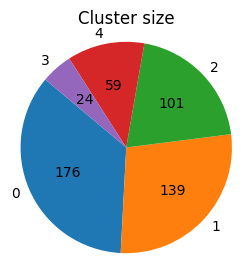

In [5]:
# cluster overview 
cluster_counts = filtered_cluster_labels['cluster'].value_counts()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}'
    return my_autopct

plt.figure(figsize=(3,3))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct=make_autopct(cluster_counts), startangle=140)
plt.title('Cluster size')
plt.axis('equal')
plt.show()

### survival analysis 

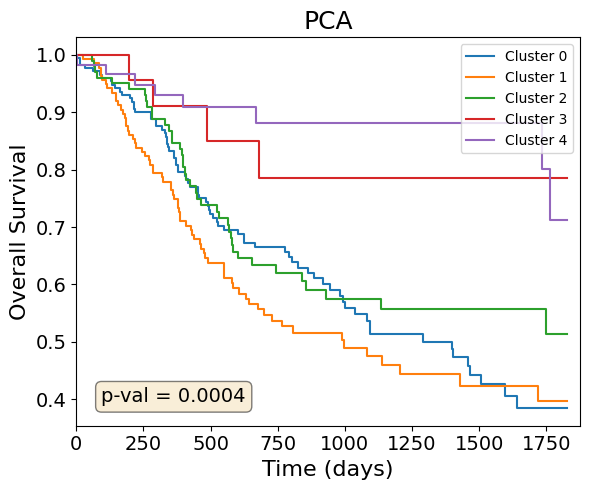

<lifelines.CoxPHFitter: fitted with 499 total observations, 283 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 499
number of events observed = 216
   partial log-likelihood = -1164.03
         time fit was run = 2025-04-19 01:01:46 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1  0.17      1.18      0.16           -0.15            0.48                0.86                1.62
cluster_2 -0.18      0.84      0.19           -0.55            0.19                0.58                1.21
cluster_3 -0.90      0.41      0.46           -1.80            0.01                0.17                1.01
cluster_4 -1.06      0.35      0.32           -1.68           -0.43                0.19                0.65

           cmp to     z      p  -log2(p)
covariate                               
cluster_1    0.00  1.05   0.30      1.76
cluster_2    0.00 -0.94   0.35      1.53
cluster_3    0.00 -1.94   0.05      4.25
cluster_4    0.00 -3.28 <0.005      9.93
---
Concordance = 0.59
Partial AIC = 2336.06
log-likelihood ratio test = 24.26 on 4 df
-log2(p) of ll-ratio test = 13.79

AttributeError: Line2D.set() got an unexpected keyword argument 'figsize'

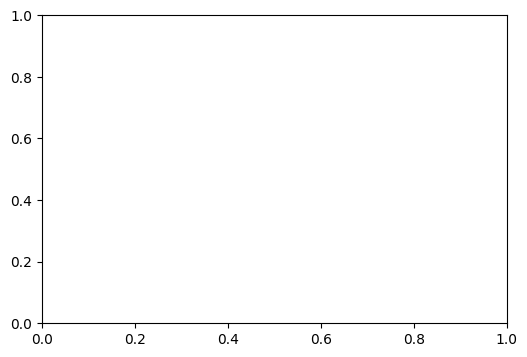

In [11]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for OS
# -------------------------------------------------
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt
import numpy as np

kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 5))

cutoff_days = 5 * 365
timeline = np.linspace(0, cutoff_days, 500)

for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['OS_time'], timeline=timeline, event_observed=cluster_df['OS'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)

logrank_results = multivariate_logrank_test(df['OS_time'], df['cluster'], event_observed=df['OS'])

plt.title("PCA", fontsize=18)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Overall Survival", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, cutoff_days + 50)

# Legend inside top right
plt.legend(loc='upper right', fontsize=10, frameon=True)

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
df['cluster'] = df['cluster'].astype(str)
df_encoded = pd.get_dummies(df[['cluster']], drop_first=True)
df_model = pd.concat([df[['OS_time', 'OS']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='OS_time', event_col='OS')
cph.print_summary()

plt.figure(figsize=(6, 4))
cph.plot(figsize=(6, 4), fontsize=14)
plt.title("Cox Model Coefficients with 95% CIs", fontsize=18)
plt.xlabel("Coefficient (log hazard ratio)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.show()


### Metadata Annotation

#### Overview

In [17]:
variables = ['tumor_stage', 'tumor_site', 'tumor_class', "gender"]
for var in variables:
    total = df.shape[0]
    missing = df[var].isna().sum()
    percent_missing = (missing / total) * 100
    print(f"{var}: {missing} missing ({percent_missing:.2f}%)")

tumor_stage: 148 missing (29.66%)
tumor_site: 0 missing (0.00%)
tumor_class: 0 missing (0.00%)
gender: 0 missing (0.00%)


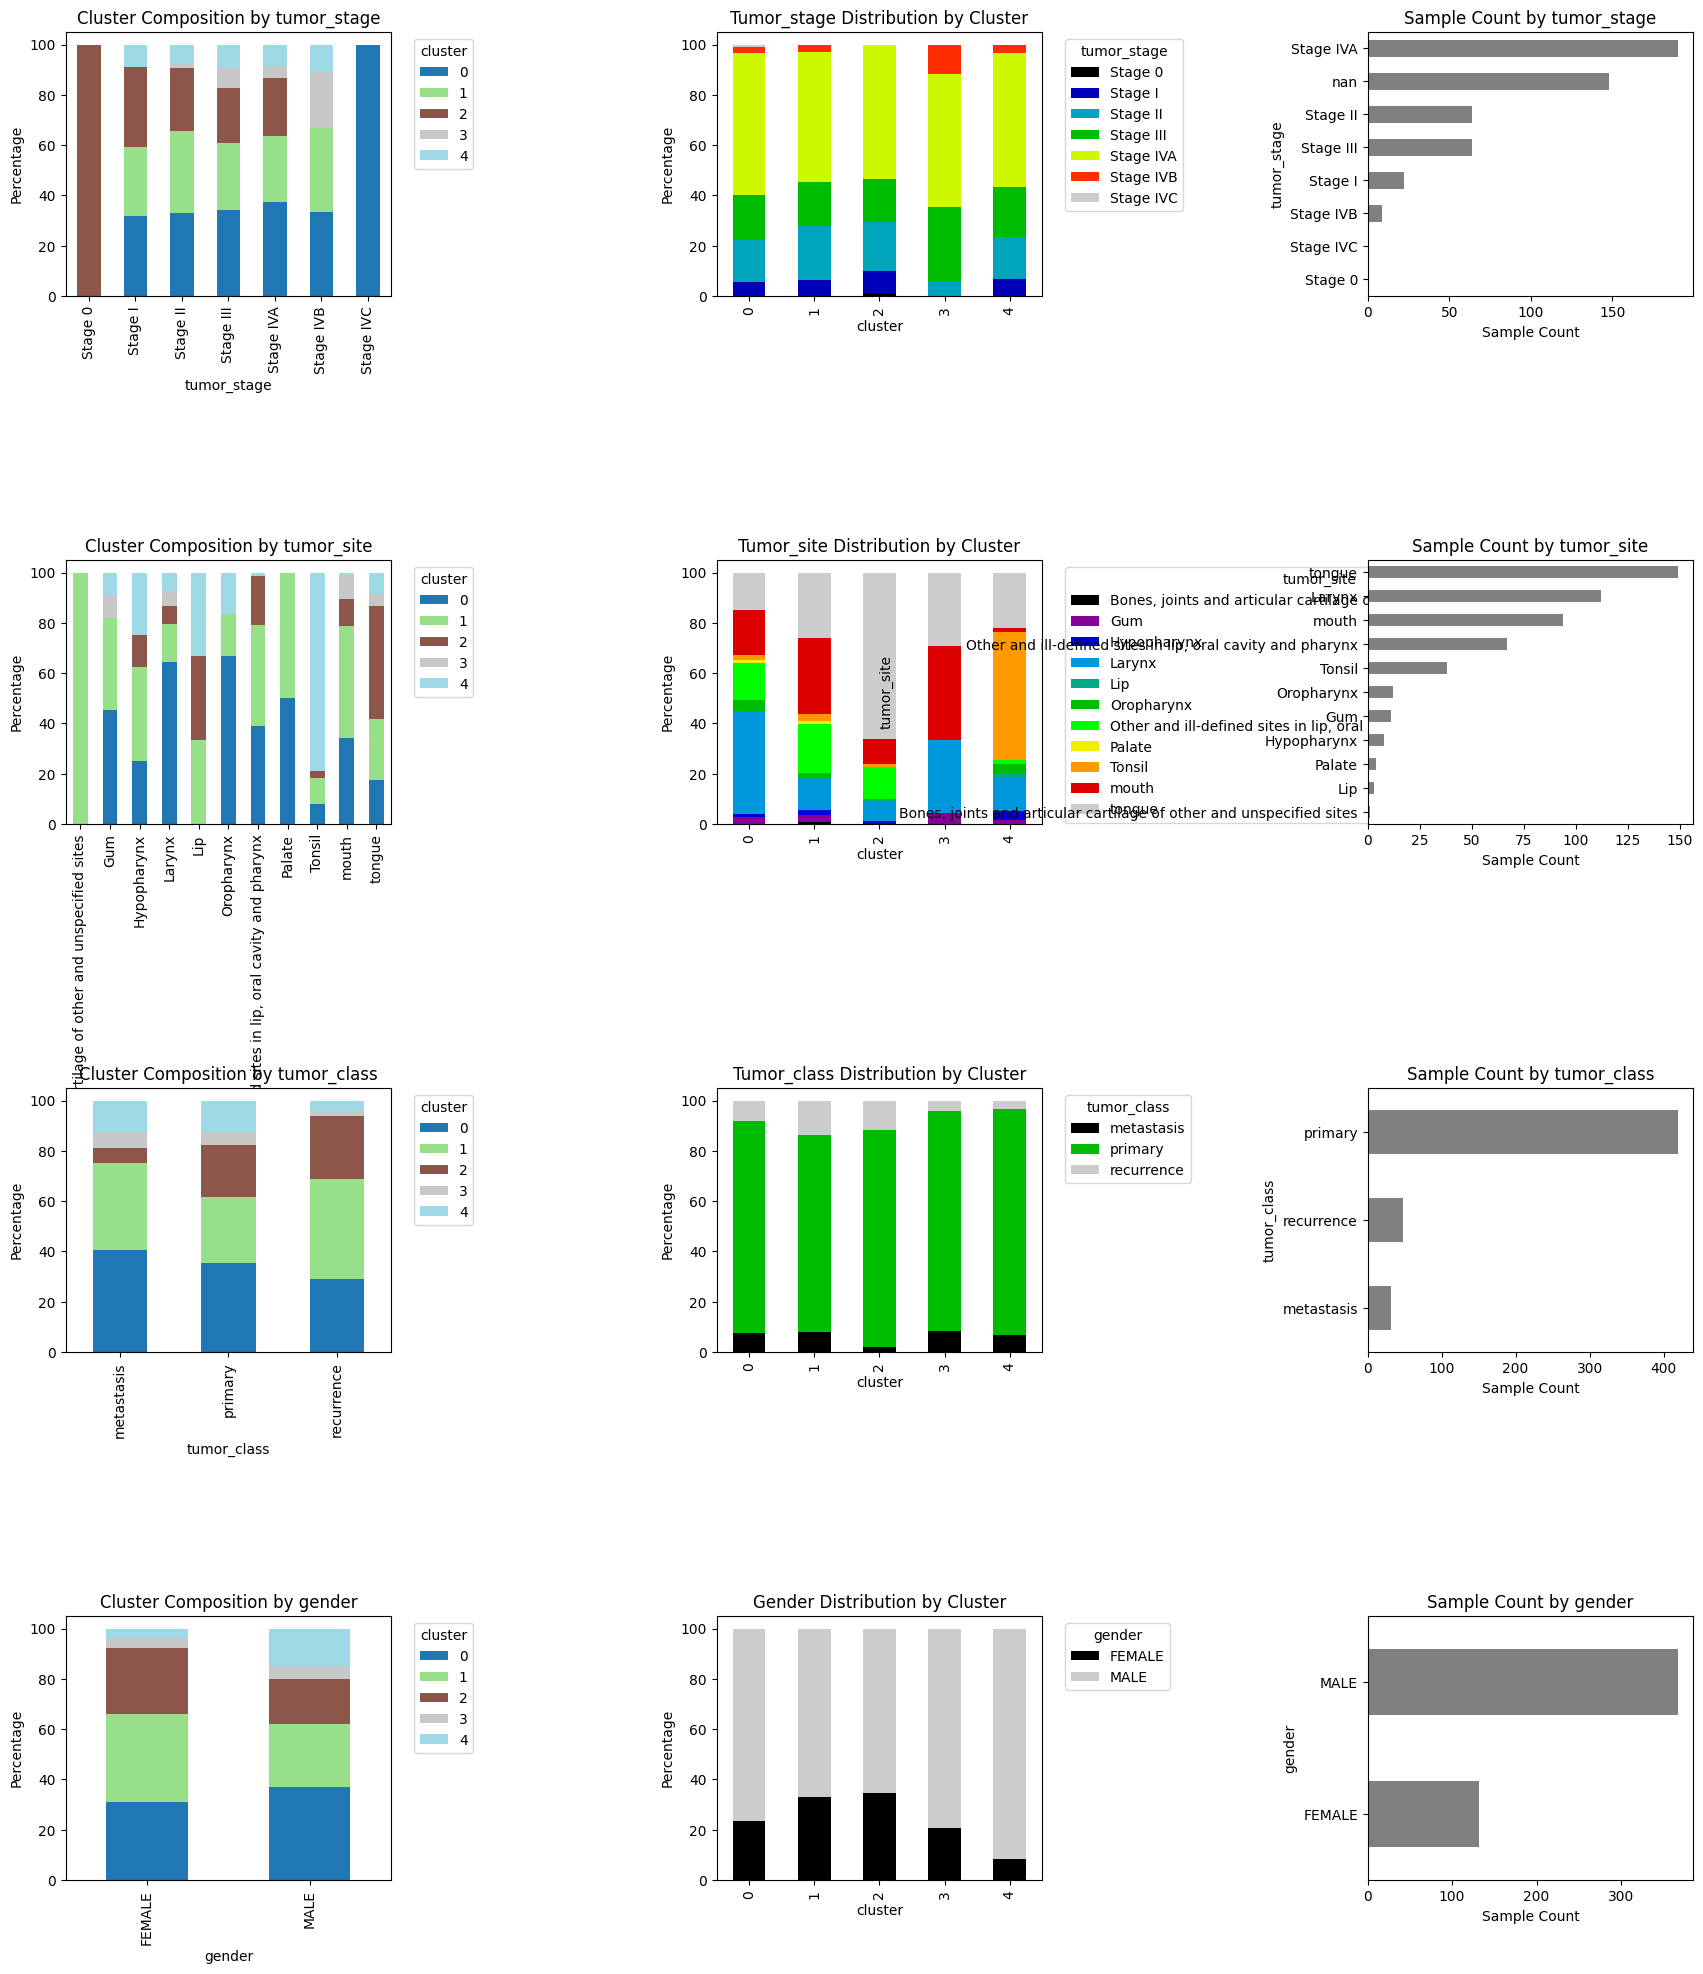

In [18]:
fig, axes = plt.subplots(
    nrows=len(variables),
    ncols=3,
    figsize=(21, 6 * len(variables)),
    gridspec_kw={'hspace': 1, 'wspace': 1}  # space between rows and columns
)

for i, var in enumerate(variables):
    # Cluster composition by category
    ct1 = pd.crosstab(df[var], df['cluster'], normalize='index') * 100
    ct1.plot(kind='bar', stacked=True, ax=axes[i, 0], colormap='tab20')
    axes[i, 0].set_ylabel('Percentage')
    axes[i, 0].set_title(f'Cluster Composition by {var}')
    axes[i, 0].legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Category distribution by cluster
    ct2 = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
    ct2.plot(kind='bar', stacked=True, ax=axes[i, 1], colormap='nipy_spectral')
    axes[i, 1].set_ylabel('Percentage')
    axes[i, 1].set_title(f'{var.capitalize()} Distribution by Cluster')
    axes[i, 1].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Horizontal bar chart of raw counts
    value_counts = df[var].value_counts(dropna=False).sort_values()
    value_counts.plot.barh(ax=axes[i, 2], color='gray')
    axes[i, 2].set_xlabel('Sample Count')
    axes[i, 2].set_title(f'Sample Count by {var}')

plt.show()


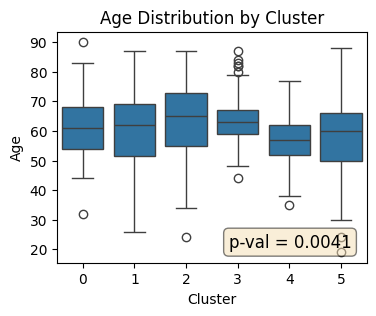

In [30]:
# ============================================================
# Create Boxplot: Age distribution by Cluster
# ============================================================
order = sorted(df['cluster'].unique())

groups = [df[df['cluster'] == cluster]['age'] for cluster in df['cluster'].unique()]
anova_result = stats.f_oneway(*groups)
p_val = anova_result.pvalue

plt.figure(figsize=(4, 3))
sns.boxplot(x='cluster', y='age', data=df, order=order)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

ax = plt.gca()
ax.text(0.95, 0.05, f"p-val = {p_val:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

#### Enrichment by tumor sites

In [20]:
# Define categories to group
small_sites = [
    'Bones, joints and articular cartilage of other and unspecified sites',
    'Lip', 'Palate', 'Hypopharynx', 'Gum', 'Oropharynx',
]

df['tumor_site'] = df['tumor_site'].replace('Other and ill-defined sites in lip, oral cavity and pharynx', 'ill defined sites')
df['tumor_site'] = df['tumor_site'].replace(small_sites, 'Others')

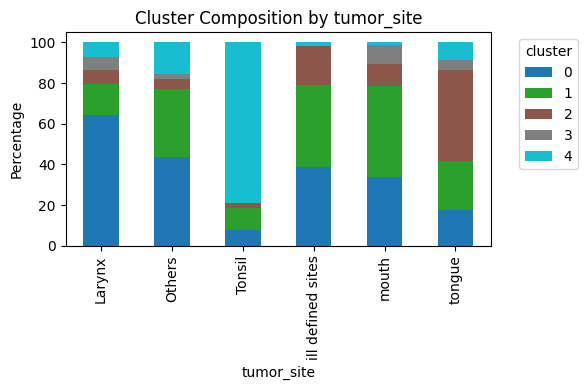

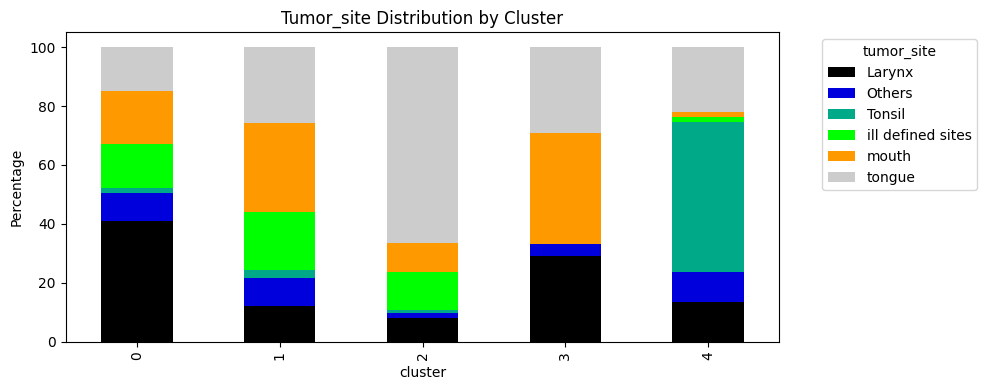

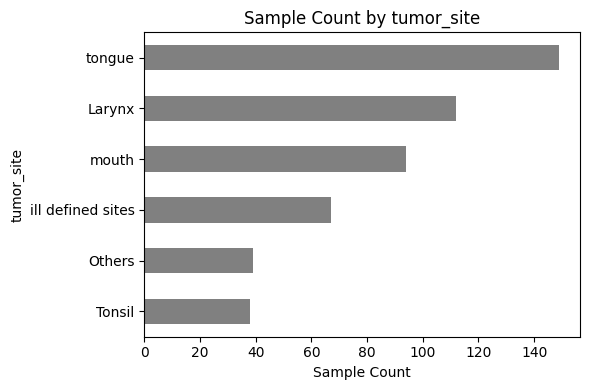

In [21]:
var = 'tumor_site'

# 1. Cluster composition by tumor_site
ct1 = pd.crosstab(df[var], df['cluster'], normalize='index') * 100
ct1.plot(kind='bar', stacked=True, colormap='tab10', figsize=(6, 4))
plt.ylabel('Percentage')
plt.title(f'Cluster Composition by {var}')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Tumor_site distribution by cluster
ct2 = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
ct2.plot(kind='bar', stacked=True, colormap='nipy_spectral', figsize=(10, 4))
plt.ylabel('Percentage')
plt.title(f'{var.capitalize()} Distribution by Cluster')
plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Raw count of tumor_site
value_counts = df[var].value_counts(dropna=False).sort_values()
value_counts.plot.barh(color='gray', figsize=(6, 4))
plt.xlabel('Sample Count')
plt.title(f'Sample Count by {var}')
plt.tight_layout()
plt.show()


#### additional metadata + source site bias

In [32]:
metadata_enr = pd.read_csv("../../Data/processed/sample_metadata_enriched.tsv", sep="\t")
# clean up
metadata_enr['race'] = metadata_enr['race'].replace({
    '[Not Available]': "NaN",
    '[Unknown]': "NaN",
    '[Not Evaluated]': "NaN"
})
metadata_enr = metadata_enr.drop(columns=['Redaction','radiation_therapy','postoperative_rx_tx',
                                          'history_of_neoadjuvant_treatment','hpv_status_by_ish_testing',
                                         'hpv_status_by_p16_testing','primary_therapy_outcome_success',
                                          'p53_gene_analysis','egfr_amplication_status'])
metadata_enr['number_pack_years_smoked'] = metadata_enr['number_pack_years_smoked'].replace(
    '[Not Available]', "NaN"
).astype(float)
metadata_enr['frequency_of_alcohol_consumption'] = metadata_enr['number_pack_years_smoked'].replace(
    '[Not Available]', "NaN"
).astype(float)
metadata_enr['amount_of_alcohol_consumption_per_day'] = metadata_enr['number_pack_years_smoked'].replace(
    '[Not Available]', "NaN"
).astype(float)
metadata_enr['number_pack_years_smoked_binned'] = pd.cut(
    metadata_enr['number_pack_years_smoked'],
    bins=[0, 10, 20, 30, 40, 50, 100],
    labels=['0–10', '10–20', '20–30', '30–40', '40–50', '50+']
)
metadata_enr['frequency_of_alcohol_consumption_binned'] = pd.cut(
    metadata_enr['frequency_of_alcohol_consumption'],
    bins=[0, 10, 20, 30, 40, 50, 100],
    labels=['0–10', '10–20', '20–30', '30–40', '40–50', '50+']
)
# throw out columns if it has less than 50% entries
threshold = 0.5  # 50%
metadata_enr = metadata_enr.loc[:, metadata_enr.isna().mean() <= threshold]
for var in metadata_enr.columns:
    total = metadata_enr.shape[0]
    missing = metadata_enr[var].isna().sum()
    percent_missing = (missing / total) * 100
    print(f"{var}: {missing} missing ({percent_missing:.2f}%)")

sample_id: 0 missing (0.00%)
patient_id: 0 missing (0.00%)
type: 0 missing (0.00%)
age_at_initial_pathologic_diagnosis: 0 missing (0.00%)
gender: 0 missing (0.00%)
race: 0 missing (0.00%)
ajcc_pathologic_tumor_stage: 0 missing (0.00%)
histological_type: 0 missing (0.00%)
histological_grade: 0 missing (0.00%)
tumor_status: 31 missing (5.69%)
vital_status: 0 missing (0.00%)
OS: 0 missing (0.00%)
OS.time: 0 missing (0.00%)
DSS: 29 missing (5.32%)
DSS.time: 0 missing (0.00%)
PFI: 0 missing (0.00%)
PFI.time: 0 missing (0.00%)
Source Site: 0 missing (0.00%)
BCR: 0 missing (0.00%)
sample_type: 0 missing (0.00%)
bcr_patient_barcode: 209 missing (38.35%)
ajcc_clinical_group_stage: 240 missing (44.04%)
ajcc_clinical_primary_tumor_t_stage: 240 missing (44.04%)
ajcc_clinical_primary_tumor_n_stage: 240 missing (44.04%)
ajcc_clinical_primary_tumor_m_stage: 240 missing (44.04%)
tumor_stage: 248 missing (45.50%)
tobacco_smoking_history_indicator: 218 missing (40.00%)
alcohol_history_documented: 216 mi

In [21]:
# Raw counts
raw_counts = df.groupby("Source Site")['cluster'].value_counts().unstack().fillna(0).astype(int)

# Percentages
percentages = raw_counts.div(raw_counts.sum(axis=1), axis=0).round(2)

# Combine both into a formatted DataFrame
combined = raw_counts.astype(str) + " (" + (percentages * 100).round(1).astype(str) + "%)"

# Display
import pandas as pd
pd.set_option('display.max_columns', None)
combined

# Rank by total sample count per source site
total_counts = raw_counts.sum(axis=1)
combined_sorted = combined.loc[total_counts.sort_values(ascending=False).index]

combined_sorted

cluster,0,1,2,3,4
Source Site,,,,,
MD Anderson Cancer Center,36 (21.0%),39 (23.0%),49 (29.0%),38 (22.0%),8 (5.0%)
University of Pittsburgh,12 (17.0%),19 (27.0%),20 (28.0%),12 (17.0%),8 (11.0%)
Vanderbilt University,4 (8.0%),13 (25.0%),12 (23.0%),6 (11.0%),18 (34.0%)
"University Health Network, Toronto",11 (30.0%),8 (22.0%),6 (16.0%),12 (32.0%),0 (0.0%)
UNC,16 (46.0%),2 (6.0%),7 (20.0%),6 (17.0%),4 (11.0%)
Greater Poland Cancer Center,5 (25.0%),5 (25.0%),3 (15.0%),5 (25.0%),2 (10.0%)
Barretos Cancer Hospital,4 (21.0%),3 (16.0%),10 (53.0%),1 (5.0%),1 (5.0%)
Emory University - Winship Cancer Inst.,4 (24.0%),2 (12.0%),5 (29.0%),3 (18.0%),3 (18.0%)
International Genomics Consortium,4 (24.0%),7 (41.0%),1 (6.0%),4 (24.0%),1 (6.0%)
